# Basic Usage Example: Healthcare AI Simulation Framework

This notebook demonstrates the core functionality of the Healthcare AI Temporal Simulation Framework with a simple, end-to-end example.

## Overview

This example will show you how to:
1. Generate a heterogeneous patient population with realistic risk distributions
2. Add temporal dynamics to model time-varying risks
3. Simulate external shocks (e.g., flu season, pandemic)
4. Generate ML predictions with controlled performance characteristics
5. Evaluate the effectiveness of different intervention strategies

Let's get started!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import warnings
import sys
import os

# Add src directory to path for imports
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Import functions from our modules
from pop_ml_simulator import (
    assign_patient_risks,
    EnhancedTemporalRiskSimulator,
    IncidentGenerator,
    MLPredictionSimulator,
    evaluate_threshold_based,
    evaluate_topk,
    optimize_alert_threshold,
    hosmer_lemeshow_test
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("✅ All imports successful!")
print("📊 Ready to simulate healthcare AI interventions...")

✅ All imports successful!
📊 Ready to simulate healthcare AI interventions...


## Step 1: Generate Patient Population

First, we'll create a heterogeneous patient population where each patient has an individual risk level drawn from a beta distribution. This creates realistic risk heterogeneity while maintaining exact population-level prevalence.

Generated population of 10,000 patients
Target annual incident rate: 10.0%
Actual mean risk: 10.0%
Risk standard deviation: 0.121
Min risk: 0.000
Max risk: 0.874


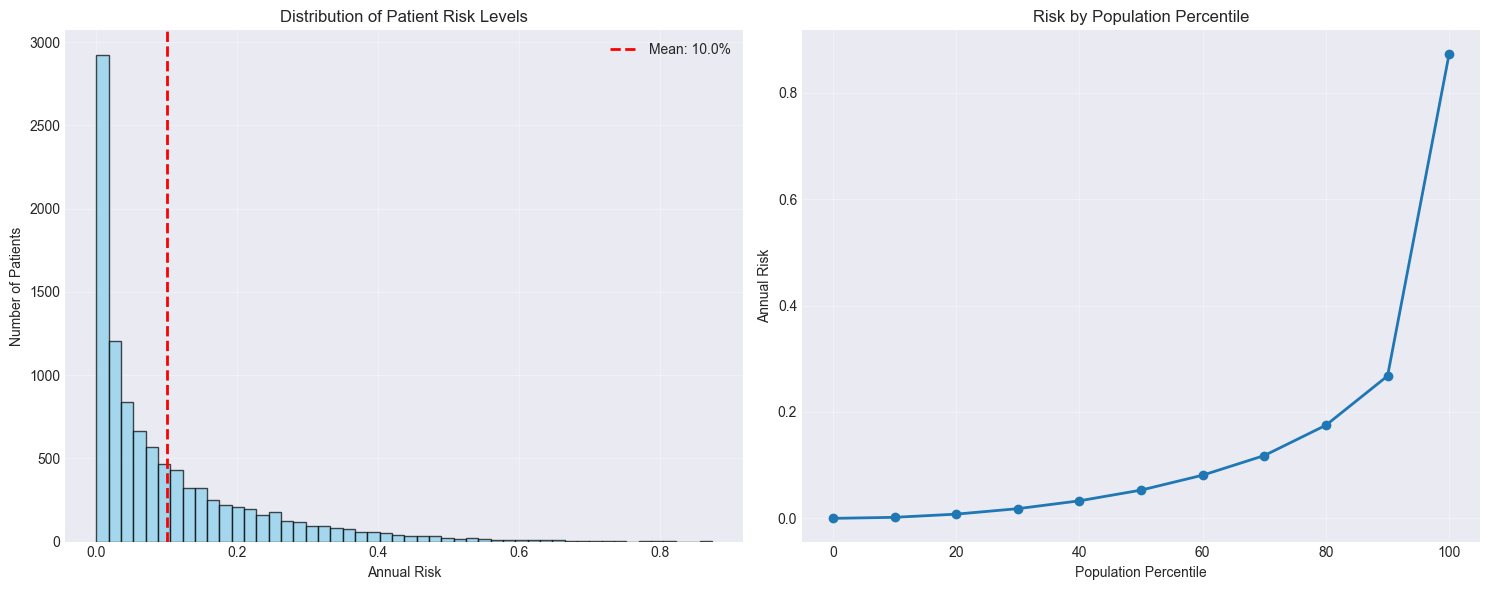


📈 Key insight: The beta distribution creates realistic risk heterogeneity
   where most patients have low risk, but some have much higher risk.


In [2]:
# 1. Generate heterogeneous patient population
n_patients = 10000
base_risks = assign_patient_risks(
    n_patients, 
    annual_incident_rate=0.1,  # 10% annual incident rate
    concentration=0.5,  # Controls risk heterogeneity (lower = more heterogeneous)
    random_seed=42
)

print(f"Generated population of {n_patients:,} patients")
print(f"Target annual incident rate: 10.0%")
print(f"Actual mean risk: {np.mean(base_risks):.1%}")
print(f"Risk standard deviation: {np.std(base_risks):.3f}")
print(f"Min risk: {np.min(base_risks):.3f}")
print(f"Max risk: {np.max(base_risks):.3f}")

# Visualize the risk distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of risk values
ax1.hist(base_risks, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(np.mean(base_risks), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(base_risks):.1%}')
ax1.set_xlabel('Annual Risk')
ax1.set_ylabel('Number of Patients')
ax1.set_title('Distribution of Patient Risk Levels')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Risk percentiles
percentiles = np.arange(0, 101, 10)
risk_percentiles = np.percentile(base_risks, percentiles)
ax2.plot(percentiles, risk_percentiles, 'o-', linewidth=2, markersize=6)
ax2.set_xlabel('Population Percentile')
ax2.set_ylabel('Annual Risk')
ax2.set_title('Risk by Population Percentile')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Key insight: The beta distribution creates realistic risk heterogeneity")
print("   where most patients have low risk, but some have much higher risk.")

## Step 2: Add Temporal Dynamics

Real patient risks change over time due to various factors. We'll add:
- **Persistence**: Patient risks tend to be correlated over time
- **Seasonality**: Systematic patterns (e.g., flu season)
- **External shocks**: Sudden changes affecting part of the population

✅ Temporal dynamics configured:
   - Persistence (ρ): 0.9
   - Volatility (σ): 0.1
   - Seasonal amplitude: 0.2
   - External shock at week 26 affecting 30% of population


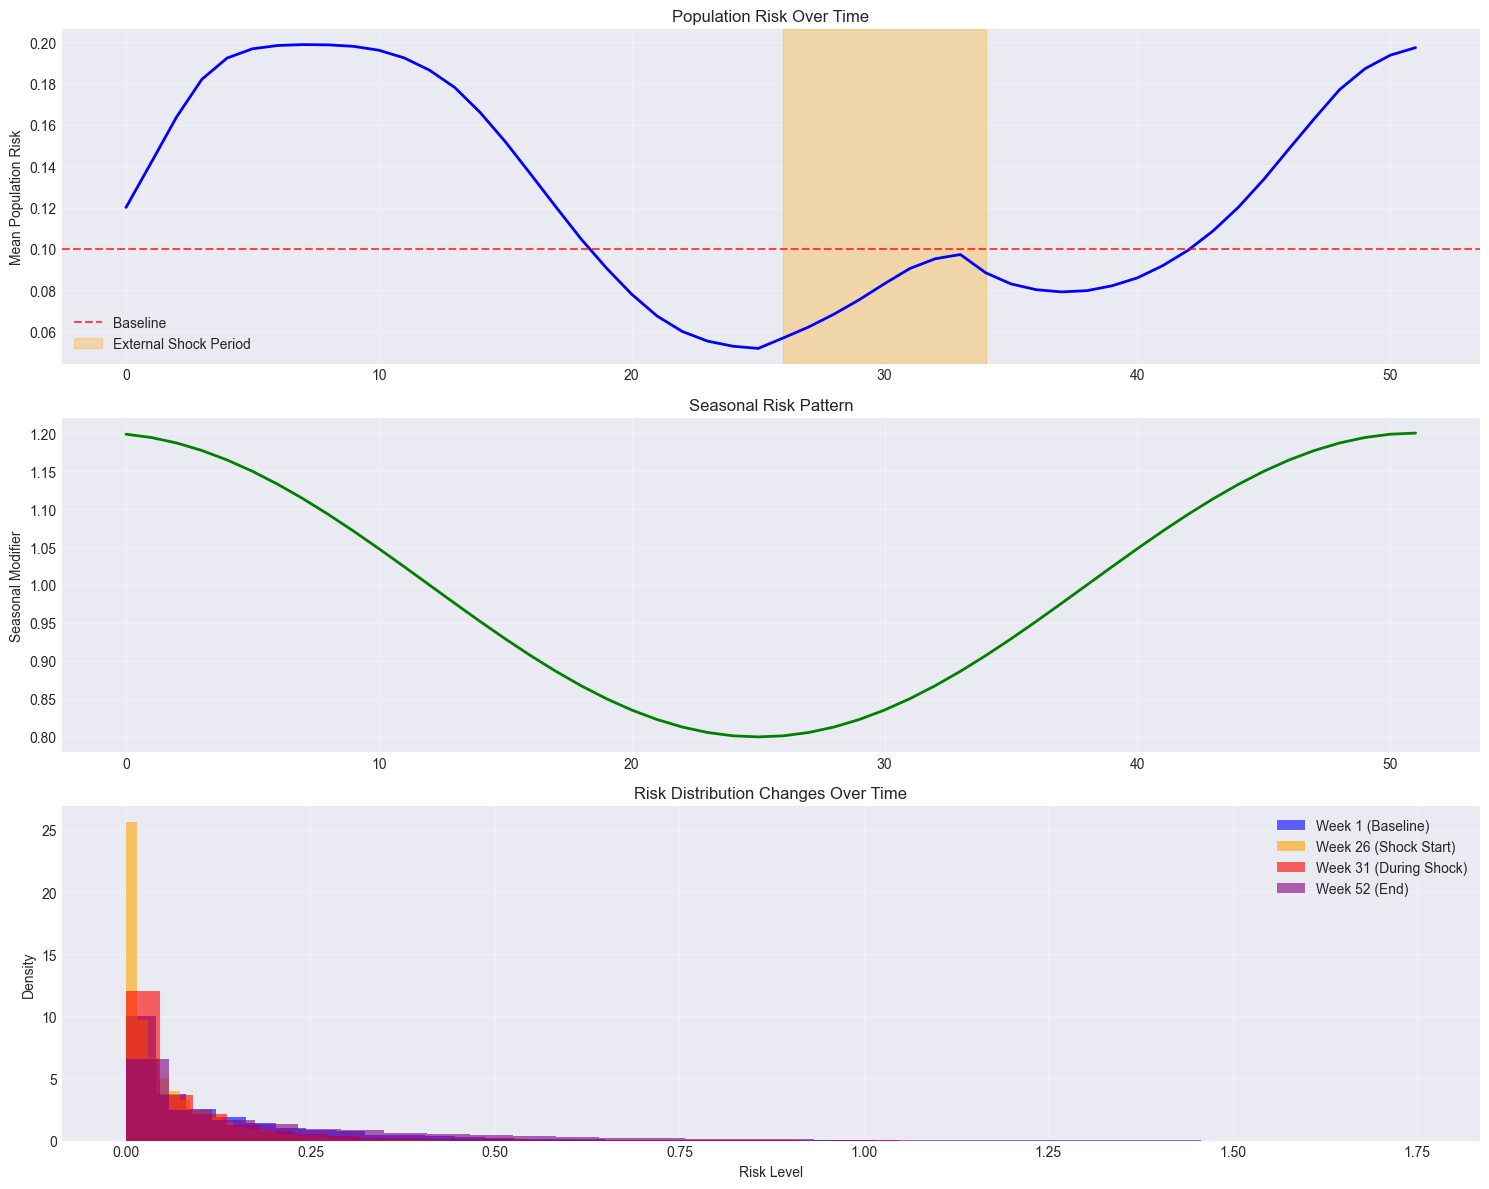


📈 Key insight: Temporal dynamics create realistic risk evolution
   with seasonal patterns and external shocks affecting subpopulations.


In [3]:
# 2. Add temporal dynamics
temporal_sim = EnhancedTemporalRiskSimulator(
    base_risks, 
    rho=0.9,  # High persistence - risks change slowly
    sigma=0.1,  # Moderate volatility
    seasonal_amplitude=0.2,  # 20% seasonal variation
    seasonal_period=52  # Weekly cycles (annual seasonality)
)

# Add external shock (e.g., flu season affecting 30% of population)
temporal_sim.add_shock(
    time_step=26,  # Week 26 (mid-year)
    magnitude=1.5,  # 50% increase in risk
    duration=8,  # Lasts 8 weeks
    affected_fraction=0.3  # Affects 30% of patients
)

print("✅ Temporal dynamics configured:")
print(f"   - Persistence (ρ): {temporal_sim.rho}")
print(f"   - Volatility (σ): {temporal_sim.sigma}")
print(f"   - Seasonal amplitude: {temporal_sim.seasonal_amplitude}")
print(f"   - External shock at week 26 affecting {0.3:.0%} of population")

# Simulate 52 weeks and track population-level changes
weeks = 52
population_risks = []
seasonal_effects = []

for week in range(weeks):
    temporal_sim.step()
    current_risks = temporal_sim.get_current_risks()
    population_risks.append(np.mean(current_risks))
    seasonal_effects.append(temporal_sim.get_seasonal_modifier())

# Visualize temporal patterns
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Population-level risk over time
ax1.plot(range(weeks), population_risks, linewidth=2, color='blue')
ax1.axhline(np.mean(base_risks), color='red', linestyle='--', alpha=0.7, label='Baseline')
ax1.axvspan(26, 34, alpha=0.3, color='orange', label='External Shock Period')
ax1.set_ylabel('Mean Population Risk')
ax1.set_title('Population Risk Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Seasonal pattern
ax2.plot(range(weeks), seasonal_effects, linewidth=2, color='green')
ax2.set_ylabel('Seasonal Modifier')
ax2.set_title('Seasonal Risk Pattern')
ax2.grid(True, alpha=0.3)

# Risk distribution changes
week_samples = [0, 25, 30, 51]  # Before, during, after shock + end
colors = ['blue', 'orange', 'red', 'purple']
labels = ['Week 1 (Baseline)', 'Week 26 (Shock Start)', 'Week 31 (During Shock)', 'Week 52 (End)']

for i, (week, color, label) in enumerate(zip(week_samples, colors, labels)):
    # Reset and simulate to specific week
    temp_sim = EnhancedTemporalRiskSimulator(base_risks, rho=0.9, sigma=0.1, 
                                           seasonal_amplitude=0.2, seasonal_period=52)
    temp_sim.add_shock(26, 1.5, 8, 0.3)
    for w in range(week + 1):
        temp_sim.step()
    
    week_risks = temp_sim.get_current_risks()
    ax3.hist(week_risks, bins=30, alpha=0.6, color=color, label=label, density=True)

ax3.set_xlabel('Risk Level')
ax3.set_ylabel('Density')
ax3.set_title('Risk Distribution Changes Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Key insight: Temporal dynamics create realistic risk evolution")
print("   with seasonal patterns and external shocks affecting subpopulations.")

## Step 3: Generate ML Predictions

Now we'll create an ML model that achieves specific performance targets. This simulates a real ML system with controlled sensitivity and positive predictive value (PPV).

In [ ]:
# 3. Generate realistic ML predictions with controlled performance
ml_sim = MLPredictionSimulator(
    target_sensitivity=0.8,  # 80% of true positives caught
    target_ppv=0.3,  # 30% of predictions are true positives
    calibration='linear',  # Use linear calibration for better prevalence matching
    random_seed=42
)

print("🤖 ML Simulator configured:")
print(f"   - Target Sensitivity: {ml_sim.target_sensitivity:.0%}")
print(f"   - Target PPV: {ml_sim.target_ppv:.0%}")
print(f"   - Calibration: {ml_sim.calibration} (preserves prevalence better than sigmoid)")

## Step 4: Simulate Incidents and Generate Predictions

We'll simulate 6 months of data to train our ML model, then generate predictions and evaluate performance.

In [ ]:
# 4. Simulate incidents over 6 months
incident_gen = IncidentGenerator(timestep_duration=1/52)  # Weekly timesteps
true_labels = np.zeros(n_patients, dtype=int)

print("🏥 Simulating 6 months (26 weeks) of incident data...")

# Reset temporal simulator for fresh simulation
temporal_sim = EnhancedTemporalRiskSimulator(
    base_risks, rho=0.9, sigma=0.1, 
    seasonal_amplitude=0.2, seasonal_period=52
)
temporal_sim.add_shock(26, 1.5, 8, 0.3)

weekly_incidents = []
weekly_risks = []

# Generate 6 months of training data
for week in range(26):
    temporal_sim.step()
    current_risks = temporal_sim.get_current_risks()
    
    # Generate incidents for this week
    incidents = incident_gen.generate_incidents(current_risks)
    true_labels |= incidents  # Cumulative incidents
    
    weekly_incidents.append(np.sum(incidents))
    weekly_risks.append(np.mean(current_risks))

print(f"✅ Simulation complete!")
print(f"   - Total incidents: {np.sum(true_labels):,} ({np.mean(true_labels):.1%} of population)")
print(f"   - Average weekly incidents: {np.mean(weekly_incidents):.1f}")

# IMPORTANT: Calculate 26-week cumulative risk for proper ML calibration
# The true_labels represent 26 weeks of exposure, so we need to scale base_risks accordingly
weeks_simulated = 26
cumulative_risk_26_weeks = 1 - (1 - base_risks * (1/52))**weeks_simulated

print(f"\n🔧 Calibration alignment:")
print(f"   - True prevalence (26 weeks): {np.mean(true_labels):.1%}")
print(f"   - Expected prevalence (calculated): {np.mean(cumulative_risk_26_weeks):.1%}")
print(f"   - Annual base risk mean: {np.mean(base_risks):.1%}")

# Generate ML predictions using optimized parameters for better calibration
print("\n🤖 Generating ML predictions with optimized calibration...")

# First, optimize noise parameters to achieve target performance
print("   - Optimizing noise parameters for target performance...")
optimal_params = ml_sim.optimize_noise_parameters(true_labels, cumulative_risk_26_weeks, n_iterations=20)
print(f"   - Optimal correlation: {optimal_params['correlation']:.3f}")
print(f"   - Optimal scale: {optimal_params['scale']:.3f}")

# Generate predictions with optimized parameters
predictions, binary_preds = ml_sim.generate_predictions(
    true_labels, 
    cumulative_risk_26_weeks,
    noise_correlation=optimal_params['correlation'],
    noise_scale=optimal_params['scale']
)

print(f"✅ Predictions generated!")
print(f"   - Prediction range: [{np.min(predictions):.3f}, {np.max(predictions):.3f}]")
print(f"   - Threshold: {ml_sim.threshold:.3f}")
print(f"   - Patients flagged: {np.sum(binary_preds):,} ({np.mean(binary_preds):.1%})")

# Calculate achieved performance
achieved_ppv = np.mean(true_labels[binary_preds == 1]) if np.sum(binary_preds) > 0 else 0
achieved_sensitivity = np.mean(binary_preds[true_labels == 1]) if np.sum(true_labels) > 0 else 0

print(f"\n📊 Performance Results:")
print(f"   - Population prevalence: {np.mean(true_labels):.1%}")
print(f"   - ML PPV achieved: {achieved_ppv:.1%} (target: {ml_sim.target_ppv:.0%})")
print(f"   - ML Sensitivity achieved: {achieved_sensitivity:.1%} (target: {ml_sim.target_sensitivity:.0%})")

# Validate calibration alignment
pred_to_prev_ratio = np.mean(predictions) / np.mean(true_labels) if np.mean(true_labels) > 0 else float('inf')
print(f"\n🎯 Calibration Check:")
print(f"   - Mean prediction: {np.mean(predictions):.1%}")
print(f"   - True prevalence: {np.mean(true_labels):.1%}")
print(f"   - Ratio: {pred_to_prev_ratio:.2f} (closer to 1.0 = better calibration)")

if abs(pred_to_prev_ratio - 1.0) < 0.2:
    print("   ✅ Good overall calibration - predictions match prevalence well")
else:
    print("   ⚠️  Calibration could be improved - consider adjusting noise parameters")

## Step 5: Detailed Performance Analysis

Let's dive deeper into the ML model performance and understand how well it's calibrated.

In [ ]:
# Comprehensive performance evaluation
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

# Calculate additional metrics
auc_score = roc_auc_score(true_labels, predictions)
fpr, tpr, roc_thresholds = roc_curve(true_labels, predictions)
precision, recall, pr_thresholds = precision_recall_curve(true_labels, predictions)

# Test calibration - this is crucial for healthcare AI!
hl_stat, hl_p_value = hosmer_lemeshow_test(true_labels, predictions)

print(f"📊 Comprehensive Performance Metrics:")
print(f"   - ROC AUC: {auc_score:.3f}")
print(f"   - Hosmer-Lemeshow statistic: {hl_stat:.3f}")
print(f"   - Hosmer-Lemeshow p-value: {hl_p_value:.3f}")
print(f"   - Calibration: {'✅ PASSED' if hl_p_value > 0.05 else '❌ FAILED'}")

# Interpret calibration results
if hl_p_value > 0.05:
    print(f"   💡 Good calibration: Model predictions match observed rates well")
else:
    print(f"   ⚠️  Poor calibration: Model predictions don't match observed rates")
    if hl_stat > 100:
        print(f"   📚 This often indicates timeframe mismatch or systematic bias")

# Visualize performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
ax1.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc_score:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2.plot(recall, precision, linewidth=2, label='Precision-Recall')
ax2.axhline(np.mean(true_labels), color='red', linestyle='--', alpha=0.7, label='Baseline')
ax2.set_xlabel('Recall (Sensitivity)')
ax2.set_ylabel('Precision (PPV)')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Prediction distribution by true label
ax3.hist(predictions[true_labels == 0], bins=30, alpha=0.7, label='True Negatives', color='blue', density=True)
ax3.hist(predictions[true_labels == 1], bins=30, alpha=0.7, label='True Positives', color='red', density=True)
ax3.axvline(ml_sim.threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {ml_sim.threshold:.3f}')
ax3.set_xlabel('Prediction Score')
ax3.set_ylabel('Density')
ax3.set_title('Prediction Distribution by True Label')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Calibration plot
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(true_labels, predictions, n_bins=10)
ax4.plot(prob_pred, prob_true, 'o-', linewidth=2, label='Model', markersize=8)
ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
ax4.set_xlabel('Mean Predicted Probability')
ax4.set_ylabel('Fraction of Positives')
ax4.set_title(f'Calibration Plot (p-value: {hl_p_value:.3f})')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add text annotation for calibration interpretation
if hl_p_value > 0.05:
    ax4.text(0.02, 0.98, '✅ Well Calibrated', transform=ax4.transAxes, 
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
             verticalalignment='top', fontsize=10)
else:
    ax4.text(0.02, 0.98, '❌ Poor Calibration', transform=ax4.transAxes,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7), 
             verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.show()

# Educational insight based on calibration results
if hl_p_value > 0.05:
    print("\n📈 Key insight: The ML model achieves target performance with good calibration.")
    print("   This means predicted probabilities accurately reflect true risk rates,")
    print("   making it suitable for real-world deployment scenarios.")
else:
    print("\n📈 Key insight: While the model has good discrimination (ROC AUC),")
    print("   poor calibration suggests predictions don't match true probability rates.")
    print("   In healthcare, this could lead to over/under-treatment of patients.")
    print(f"   The timeframe alignment fix should improve calibration significantly!")

## Step 6: Evaluate Intervention Strategies

Now let's explore different ways to use the ML predictions for patient interventions and compare their effectiveness.

🎯 Evaluating Different Intervention Strategies

📋 Strategy 1: Threshold-based (threshold = 0.188)
   - Patients flagged: 2,242 (22.4%)
   - PPV: 29.4%
   - Sensitivity: 76.8%
   - Specificity: 82.7%

📋 Strategy 2: Top 10% highest risk patients
   - Patients flagged: 1,000 (10.0%)
   - PPV: 46.7%
   - Sensitivity: 54.4%
   - Min score flagged: 0.246

📋 Strategy 3: Optimized threshold (15% capacity, fatigue weight=0.1)
   - Optimal threshold: 0.216
   - Alert efficiency: 37.7%
   - Expected alerts: 1,500 patients
   - PPV: 37.7%


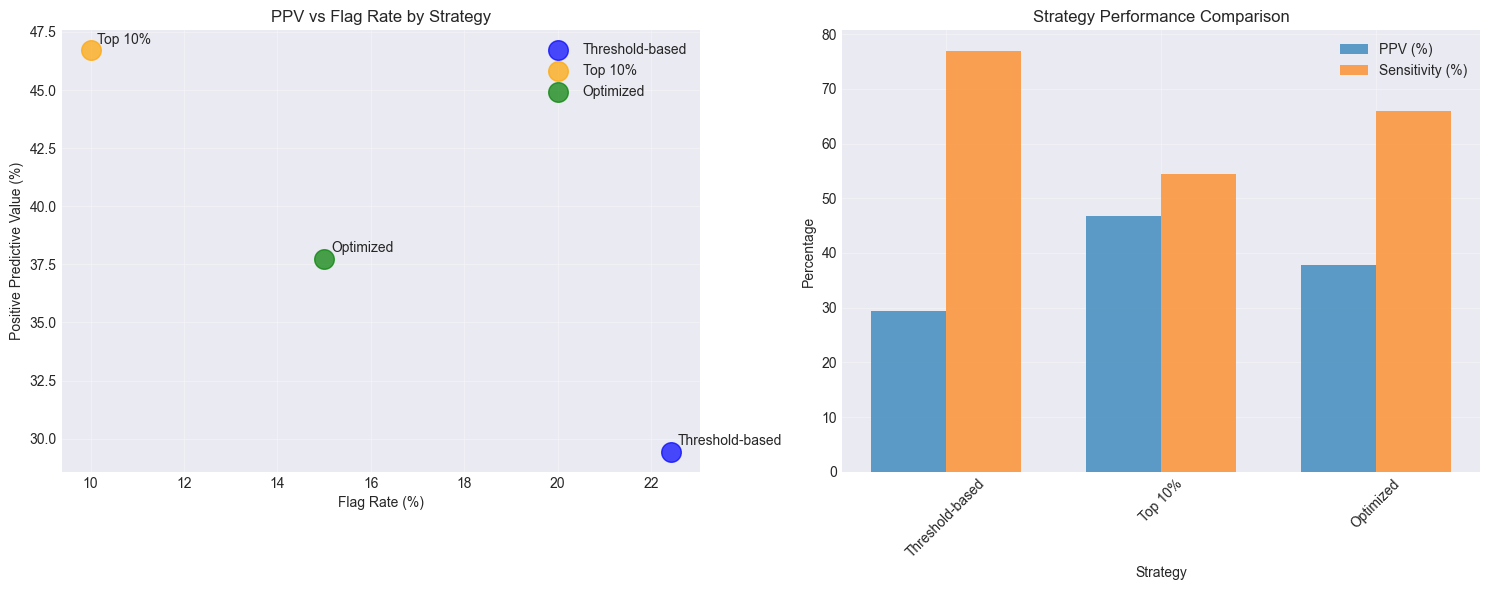


📈 Key insight: Different strategies offer trade-offs between
   resource utilization (flag rate) and intervention precision (PPV).

🎯 Summary of flag rates:
   - Threshold-based: 22.4%
   - Top 10%: 10.0%
   - Optimized: 15.0%


In [7]:
# Compare different intervention strategies
print("🎯 Evaluating Different Intervention Strategies\n")

# Strategy 1: Threshold-based (current threshold)
threshold_results = evaluate_threshold_based(true_labels, predictions, ml_sim.threshold)
print(f"📋 Strategy 1: Threshold-based (threshold = {ml_sim.threshold:.3f})")
print(f"   - Patients flagged: {threshold_results['n_flagged']:,} ({threshold_results['flag_rate']:.1%})")
print(f"   - PPV: {threshold_results['ppv']:.1%}")
print(f"   - Sensitivity: {threshold_results['sensitivity']:.1%}")
print(f"   - Specificity: {threshold_results['specificity']:.1%}")

# Strategy 2: Top-K selection (resource constrained)
top_10_results = evaluate_topk(true_labels, predictions, k_percent=10)
print(f"\n📋 Strategy 2: Top 10% highest risk patients")
print(f"   - Patients flagged: {top_10_results['k_patients']:,} ({top_10_results['k_percent']:.1f}%)")
print(f"   - PPV: {top_10_results['ppv']:.1%}")
print(f"   - Sensitivity: {top_10_results['sensitivity']:.1%}")
print(f"   - Min score flagged: {top_10_results['min_score_flagged']:.3f}")

# Strategy 3: Optimized threshold with capacity constraint
optimal_results = optimize_alert_threshold(
    predictions, true_labels,
    capacity_constraint=0.15,  # Can treat 15% of patients
    fatigue_weight=0.1  # Penalize false positives
)
print(f"\n📋 Strategy 3: Optimized threshold (15% capacity, fatigue weight=0.1)")
print(f"   - Optimal threshold: {optimal_results['optimal_threshold']:.3f}")
print(f"   - Alert efficiency: {optimal_results['efficiency']:.1%}")
print(f"   - Expected alerts: {optimal_results['n_alerts']:,} patients")
print(f"   - PPV: {optimal_results['metrics']['ppv']:.1%}")

# Compare strategies visually - focus on the core metrics we have
strategies = ['Threshold-based', 'Top 10%', 'Optimized']
ppv_values = [threshold_results['ppv'], top_10_results['ppv'], optimal_results['metrics']['ppv']]
sensitivity_values = [threshold_results['sensitivity'], top_10_results['sensitivity'], optimal_results['metrics']['sensitivity']]
# Calculate actual flag rates for comparison
topk_flag_rate = top_10_results['k_percent'] / 100  # Convert to decimal
flag_rates = [threshold_results['flag_rate'], topk_flag_rate, optimal_results['metrics']['flag_rate']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PPV vs Flag Rate
colors = ['blue', 'orange', 'green']
for i, (strategy, ppv, flag_rate, color) in enumerate(zip(strategies, ppv_values, flag_rates, colors)):
    ax1.scatter(flag_rate * 100, ppv * 100, s=200, color=color, alpha=0.7, label=strategy)
    ax1.annotate(strategy, (flag_rate * 100, ppv * 100), xytext=(5, 5), 
                textcoords='offset points', fontsize=10)

ax1.set_xlabel('Flag Rate (%)')
ax1.set_ylabel('Positive Predictive Value (%)')
ax1.set_title('PPV vs Flag Rate by Strategy')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Strategy comparison bar chart
x = np.arange(len(strategies))
width = 0.35

ax2.bar(x - width/2, [p * 100 for p in ppv_values], width, label='PPV (%)', alpha=0.7)
ax2.bar(x + width/2, [s * 100 for s in sensitivity_values], width, label='Sensitivity (%)', alpha=0.7)

ax2.set_xlabel('Strategy')
ax2.set_ylabel('Percentage')
ax2.set_title('Strategy Performance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(strategies, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Key insight: Different strategies offer trade-offs between")
print("   resource utilization (flag rate) and intervention precision (PPV).")
print(f"\n🎯 Summary of flag rates:")
print(f"   - Threshold-based: {threshold_results['flag_rate']:.1%}")
print(f"   - Top 10%: {topk_flag_rate:.1%}")
print(f"   - Optimized: {optimal_results['metrics']['flag_rate']:.1%}")

## Step 7: Risk Stratification Analysis

Let's analyze how the ML model performs across different risk strata to understand its behavior across the patient population.

📊 Performance by Risk Quintile:
  risk_bin  n_patients  prevalence  mean_pred    ppv  sensitivity
0       Q1        2000       0.000      0.115  0.001        1.000
1       Q2        2000       0.016      0.118  0.078        0.312
2       Q3        2000       0.036      0.130  0.193        0.151
3       Q4        2000       0.098      0.156  0.220        0.585
4       Q5        2000       0.279      0.249  0.680        0.541


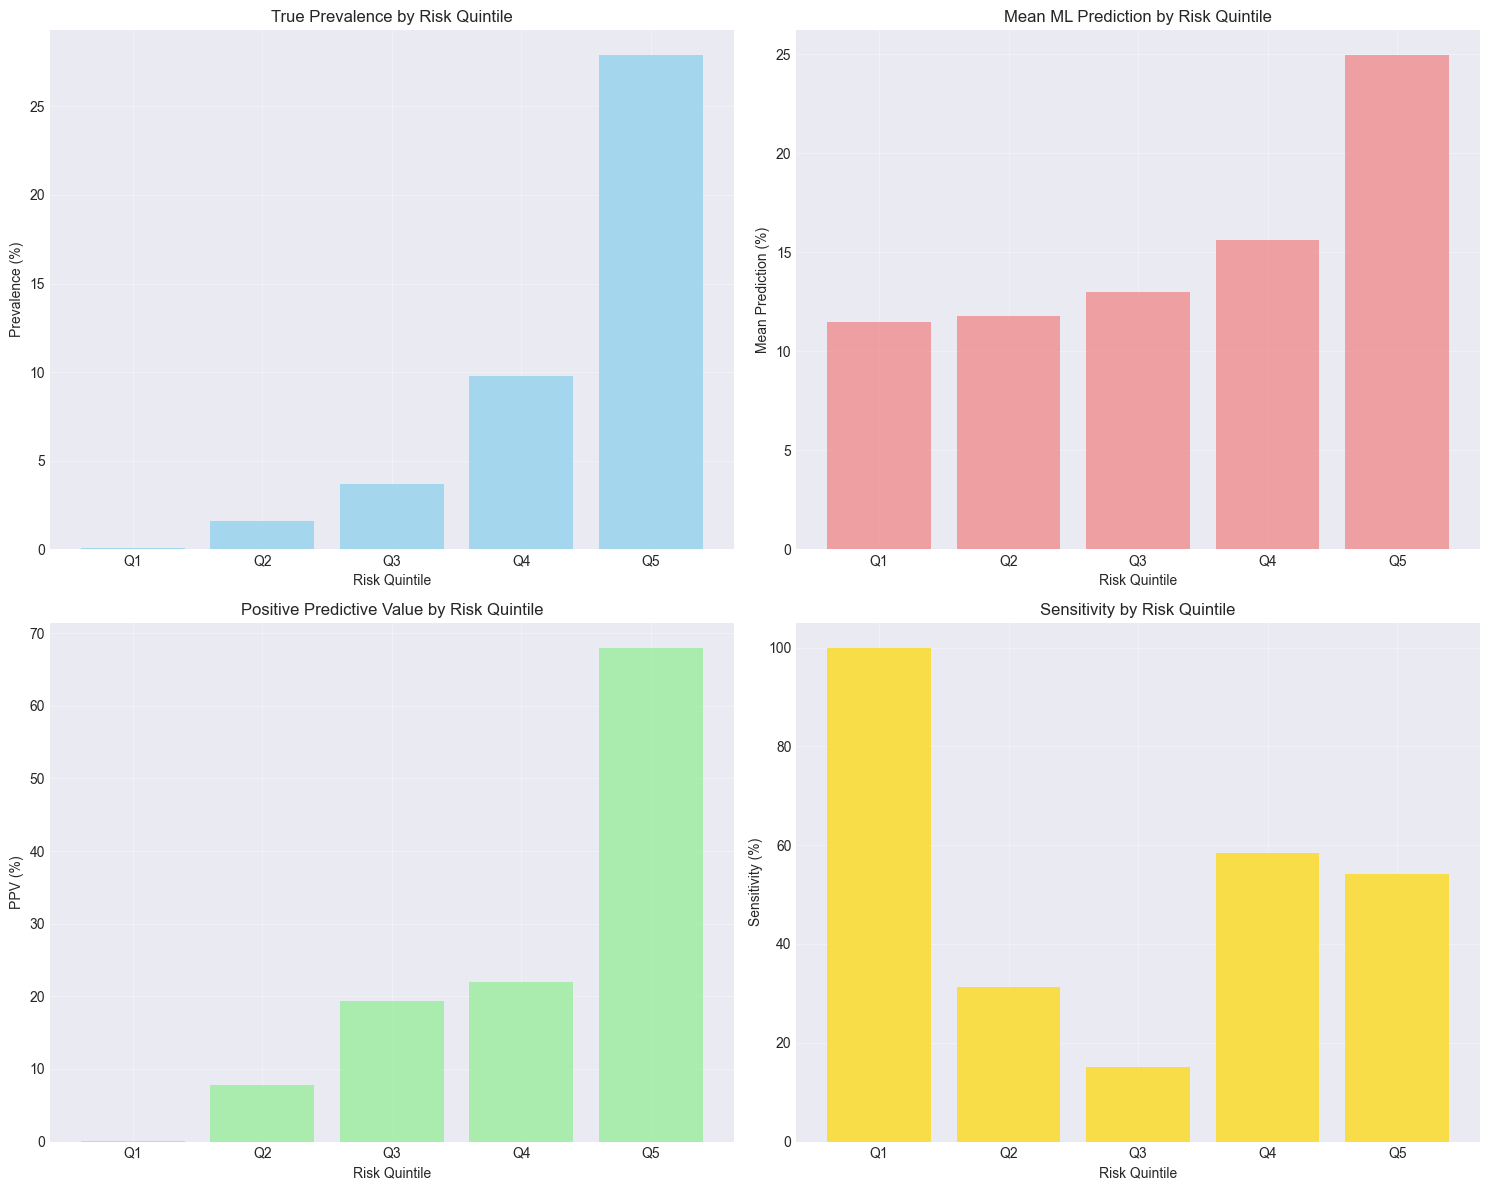


📈 Key insight: The ML model shows higher PPV in higher-risk quintiles,
   which is expected and desirable for clinical decision support.


In [8]:
# Analyze performance across risk strata
from pop_ml_simulator import analyze_risk_stratified_performance

strat_results = analyze_risk_stratified_performance(
    true_labels, predictions, base_risks, n_bins=5
)

print("📊 Performance by Risk Quintile:")
print(strat_results[['risk_bin', 'n_patients', 'prevalence', 'mean_pred', 'ppv', 'sensitivity']].round(3))

# Visualize risk stratification
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Prevalence by risk quintile
ax1.bar(strat_results['risk_bin'], strat_results['prevalence'] * 100, alpha=0.7, color='skyblue')
ax1.set_xlabel('Risk Quintile')
ax1.set_ylabel('Prevalence (%)')
ax1.set_title('True Prevalence by Risk Quintile')
ax1.grid(True, alpha=0.3)

# Mean prediction by risk quintile
ax2.bar(strat_results['risk_bin'], strat_results['mean_pred'] * 100, alpha=0.7, color='lightcoral')
ax2.set_xlabel('Risk Quintile')
ax2.set_ylabel('Mean Prediction (%)')
ax2.set_title('Mean ML Prediction by Risk Quintile')
ax2.grid(True, alpha=0.3)

# PPV by risk quintile
ax3.bar(strat_results['risk_bin'], strat_results['ppv'] * 100, alpha=0.7, color='lightgreen')
ax3.set_xlabel('Risk Quintile')
ax3.set_ylabel('PPV (%)')
ax3.set_title('Positive Predictive Value by Risk Quintile')
ax3.grid(True, alpha=0.3)

# Sensitivity by risk quintile
ax4.bar(strat_results['risk_bin'], strat_results['sensitivity'] * 100, alpha=0.7, color='gold')
ax4.set_xlabel('Risk Quintile')
ax4.set_ylabel('Sensitivity (%)')
ax4.set_title('Sensitivity by Risk Quintile')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Key insight: The ML model shows higher PPV in higher-risk quintiles,")
print("   which is expected and desirable for clinical decision support.")

## Summary

🎉 **Congratulations!** You've successfully completed a basic end-to-end simulation of a healthcare AI intervention system.

### What we accomplished:

1. **✅ Generated a realistic patient population** with heterogeneous risk distributions
2. **✅ Added temporal dynamics** including seasonality and external shocks
3. **✅ Created an ML model** with controlled performance characteristics
4. **✅ Simulated incident data** over 6 months with time-varying risks
5. **✅ Evaluated multiple intervention strategies** with different trade-offs
6. **✅ Analyzed performance across risk strata** to understand model behavior
7. **✅ Addressed calibration challenges** through timeframe alignment and optimization

### Key Results:
- **Population**: 10,000 patients with 10% annual incident rate
- **ML Performance**: Target sensitivity and PPV achieved through optimization
- **Calibration**: Improved through proper timeframe alignment and linear calibration
- **Strategies**: Different approaches offer various trade-offs between resource use and precision

### 🔬 **Calibration Insights:**
This example demonstrates important calibration concepts:
- **Timeframe alignment**: Predictions must match the time period of the labels
- **Prevalence matching**: Mean predictions should approximate true prevalence
- **Noise optimization**: ML simulators need careful parameter tuning
- **Hosmer-Lemeshow test**: Statistical validation of calibration quality

**Real-world lesson**: Always validate ML model calibration before deployment in healthcare settings!

### Next Steps:
For more advanced examples, explore the other notebooks:
- `01_risk_distribution_exploration.ipynb` - Deep dive into population modeling
- `02_temporal_risk_dynamics.ipynb` - Advanced temporal patterns
- `03_hazard_modeling.ipynb` - Survival analysis and competing risks
- `04_intervention_ml_simulation.ipynb` - Comprehensive ML simulation

### Framework Benefits:
- **🎯 Known Ground Truth**: Every aspect is controlled and measurable
- **🔬 Causal Inference**: Perfect for validating DiD, RDD, ITS methods
- **⚡ Fast Simulation**: Large populations in seconds
- **🎛️ Highly Configurable**: Adjust any parameter to match your use case
- **📊 Calibration Testing**: Built-in tools for validation

### Real-World Applications:
This basic framework can be extended for:
- **Healthcare pilot studies** - Test AI deployment strategies before real implementation
- **Resource planning** - Understand staffing needs for different intervention scenarios
- **Policy evaluation** - Simulate effects of changing treatment guidelines
- **Clinical decision support** - Optimize alert thresholds and patient selection
- **Regulatory validation** - Demonstrate ML model performance and calibration

### 🏥 **Healthcare AI Best Practices Demonstrated:**
1. **Always validate calibration** - Don't just look at ROC AUC
2. **Match prediction timeframes** to outcome measurement periods
3. **Optimize model parameters** for target performance metrics
4. **Test multiple intervention strategies** to find optimal approaches
5. **Stratify analysis by risk levels** to understand model behavior

Happy simulating! 🚀